In [1]:
import numpy as np
from matplotlib import pyplot as plt
import json
import pandas as pd
import re
import os

In [2]:

with open('transformer_encoder_test_data.json') as f1:
    data = json.load(f1)
    
print(data.keys())
# print(data['time-dur-centuries'])

print(data['factuality-factual'].keys())


dict_keys(['factuality-factual', 'genericity-arg-abstract', 'genericity-arg-kind', 'genericity-arg-particular', 'genericity-pred-dynamic', 'genericity-pred-hypothetical', 'genericity-pred-particular', 'time-dur-centuries', 'time-dur-days', 'time-dur-decades', 'time-dur-forever', 'time-dur-hours', 'time-dur-instant', 'time-dur-minutes', 'time-dur-months', 'time-dur-seconds', 'time-dur-weeks', 'time-dur-years', 'wordsense-supersense-noun.Tops', 'wordsense-supersense-noun.act', 'wordsense-supersense-noun.animal', 'wordsense-supersense-noun.artifact', 'wordsense-supersense-noun.attribute', 'wordsense-supersense-noun.body', 'wordsense-supersense-noun.cognition', 'wordsense-supersense-noun.communication', 'wordsense-supersense-noun.event', 'wordsense-supersense-noun.feeling', 'wordsense-supersense-noun.food', 'wordsense-supersense-noun.group', 'wordsense-supersense-noun.location', 'wordsense-supersense-noun.motive', 'wordsense-supersense-noun.object', 'wordsense-supersense-noun.person', 'wor

In [3]:
from scipy.stats import pearsonr 
import numpy as np

def get_true_pred(res_d, key):
    try:
        true_dict = res_d[key]['true_val_with_node_ids']
        pred_dict = res_d[key]['pred_val_with_node_ids']
        assert("protorole" not in key)
    except KeyError:
        assert("protorole" in key)
        true_dict = res_d[key]['true_val_with_edge_ids']
        pred_dict = res_d[key]['pred_val_with_edge_ids']
    true = []
    pred = []
    for key in true_dict.keys():
        true.append(true_dict[key])
        pred.append(pred_dict[key])
        
    return true, pred

def pearson(res_d):
    to_ret = {}
    for key in sorted(res_d.keys()):
        if "frompredpatt" in key:
            continue
        
        true, pred = get_true_pred(res_d, key)

        try:
            r, p = pearsonr(true, pred)
        except ValueError:
            print(f"pearson failed for key {key} val list {true}")
            continue
        to_ret[key] = (r, p, len(true))
#         print(f"key:{key}\t r:{r} \t sig:{p} \t support:{len(true)}")
    return to_ret 

def f1_helper(true, pred, thresh = 0):
    true = np.greater(true, 0)
    pred = np.greater(pred, thresh)
    # TODO: check this 
    tp = np.sum(true * pred)
    fp = np.sum((1-true) * pred)
    fn = np.sum(true * (1-pred))

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = 2*prec*rec/(prec+rec)
    if np.isnan(f1):
        return 0
    return f1

def f1_score(res_d, threshes = None):
    to_ret = {}
    for key in sorted(res_d.keys()):
        if "frompredpatt" in key:
            continue
        
        true, pred = get_true_pred(res_d, key)
        
        all_scores = []
        all_threshes = []
        if threshes is None:
            all_threshes = np.linspace(-5, 5, 500)
            for thresh in all_threshes:
                f1_score = f1_helper(true, pred, thresh)
                all_scores.append(f1_score)
        else:
            thresh = threshes[key]
            f1_score = f1_helper(true, pred, thresh)
            all_scores.append(f1_score)
            all_threshes.append(thresh)
            
        best_thresh_idx = np.argmax(all_scores)
        best_score = all_scores[best_thresh_idx]
        best_thresh = all_threshes[best_thresh_idx]

        to_ret[key] = (float(best_score * 100), best_thresh)
#         print(f"key:{key}\t r:{r} \t sig:{p} \t support:{len(true)}")
    return to_ret 

def mae_helper(true, pred):
    n = len(true)
    mae = 0
    for t, p in zip(true, pred):
        mae += abs(t-p)
    return mae / n

def mae(res_d):
    to_ret = {}
    for key in sorted(res_d.keys()):
        if "frompredpatt" in key:
            continue
        true, pred = get_true_pred(res_d, key)
        
        median_val = np.median(true)
        median_true = [median_val for i in range(len(true))]
#         pred = res_d[key]['pred_val_list']

        mae_val_empirical = mae_helper(true, pred)
    
        mae_val_baseline = mae_helper(true, median_true)
        r_val = 1 - mae_val_empirical/mae_val_baseline

        to_ret[key] = (r_val)
    return to_ret
        
        
pearson_data = pearson(data)
mae_data = mae(data)
f1_data = f1_score(data)
        
        


/home/estengel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars
/home/estengel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


In [4]:
import re
from collections import defaultdict 

TOP_TEMPLATE_MAE = """
\\begin{table}[h]
    \\centering
    \\resizebox{\columnwidth}{!}{%
    \\begin{tabular}{lll|c|c|c}
    \\hline
     & & Property & Pearson R & F1 & R1 \\\\
    \\hline
"""

TOP_TEMPLATE_FINAL = """
\\begin{table}[h]
    \\centering
    \\resizebox{\columnwidth}{!}{%
    \\begin{tabular}{lll|c|c|c}
    \\hline
     \multirow{2}{*}{} & \multirow{2}{*}{} & \multirow{2}{*}{Property} & \multirow{2}{*}{Pearson $\\rho$} & F1  & F1 \\\\
                       &                   &                           &                                 & (baseline) & (model)   \\\\ 
    \\hline
"""


TOP_TEMPLATE_NO_MAE = """
\\begin{table}[h]
    \\centering
    \\resizebox{\columnwidth}{!}{%
    \\begin{tabular}{lll|c|c}
    \\hline
     & & Property & Pearson R & F1 \\\\
    \\hline
"""

TOP_TEMPLATE_JUST_F1 = """
\\begin{table}[h]
    \\centering
    \\resizebox{\columnwidth}{!}{%
    \\begin{tabular}{lll|c}
    \\hline
     & & Property &  F1 \\\\
    \\hline
"""

END = """\\hline
    
    \\end{tabular}}
    \\caption{} 
    \\label{tab:}
\\end{table}
"""


def get_prefix(key):
    splitkey = key.split("-")
    prefix = splitkey[0]
    rest = "-".join(splitkey[1:])
    rest = re.sub("_", "-", rest)
    return prefix, rest 

def make_latex(pearson_data, mae_data, f1_data, 
               do_print = False, 
               has_mae = False, 
               threshes = None, 
               baseline = False, 
               baseline_data = None):
    
    sorting_order = ["factuality", "genericity", "time", "wordsense", "protoroles"]
    all_rs = []
    all_lens = []
    all_r1s = []
    all_f1s = []
    if threshes is not None:
        preexisting_thresh = threshes
    else:
        f1_threshes = {}
    sorted_keys = sorted(pearson_data.keys(), key = lambda x: sorting_order.index(x.split("-")[0]))
    
    if baseline_data is not None:
        baseline_data = {k:v for k, v in zip(sorted_keys, baseline_data)}
    
    to_print = []
    first_of_name = False
    prev_prefix = None
    first_of_kind = []
    type_lens = []
    tc = 0
    
    data_dict = defaultdict(list)
    
    
    for i, key in enumerate(sorted_keys):
        prefix, keyname = get_prefix(key)
        tc += 1
        if prefix != prev_prefix:
            first_of_name = True
        else:
            first_of_name = False
        if (prefix == "protoroles" and first_of_name) or (prefix == "factuality" and first_of_name):
            first_of_kind.append(i)
            if i > 0:
                type_lens.append(tc)
                tc = 0
            
        prev_prefix = prefix 
        data_dict[prefix].append((keyname, key))
        
    type_lens.append(tc)  
    
    if has_mae:
        to_print.append(TOP_TEMPLATE_MAE)
    elif baseline:
        to_print.append(TOP_TEMPLATE_JUST_F1)
    elif baseline_data is not None:
        to_print.append(TOP_TEMPLATE_FINAL)
    else:
        to_print.append(TOP_TEMPLATE_NO_MAE)
        
    tot = 0
    len_idx = 0
    for i, (prefix, lst) in enumerate(data_dict.items()):
        for j, (keyname, key) in enumerate(lst):
            
            r, p_val, support = pearson_data[key]
            mae_r1 = mae_data[key]
            f1_val = f1_data[key][0]
            f1_thresh = f1_data[key][1]
            f1_threshes[key] = f1_thresh
#             r = np.round(r, 4)
            mae_r1 = np.round(mae_r1, 4)

#             f1_val = np.round(f1_val, 2) 
            all_r1s.append(mae_r1)
            all_rs.append(r)
            all_lens.append(support)
            all_f1s.append(f1_val)
            
            # cast to  string with rounding 
            r = f"{r:.4f}"
            f1_val = f"{f1_val:.2f}"
            if p_val < 0.05:
                r = str(r) + "*" 
            else:
                r = str(r)
            
            if do_print:
                first_entry, second_entry = "", ""
                if tot in first_of_kind:
                    if i == 0:
                        t = "node-level"
                        l = type_lens[len_idx] - 1
                    else:
                        t = "edge-level"
                        l = type_lens[len_idx] + 1
                    first_entry = "\\ldelim\\{{" + str(l)  + "}{3mm}[\\parbox{3mm}" + \
                        "{\\rotatebox[origin=c]{90}{" + t + "}}]"
                    len_idx += 1
                if j == 0:
                    t = prefix
                    if prefix != "factuality":
                        second_entry = "\\ldelim\\{{" + str(len(lst))  + "}{3mm}[\\parbox{3mm}" + \
                        "{\\rotatebox[origin=c]{90}{" + t + "}}]"
                    else:
                        keyname = "factuality-factual"
                
                if has_mae:
                    line_str = " & ".join([first_entry, second_entry] + [str(x) for x in [keyname, r, f1_val, mae_r1]]) + "\\\\"
                elif baseline:
                    line_str = " & ".join([first_entry, second_entry] + [str(x) for x in [keyname, f1_val]]) + "\\\\"
                elif baseline_data is not None:
                    baseline_val = baseline_data[key]
                    baseline_val = f"{baseline_val:.2f}"
                    line_str = " & ".join([first_entry, second_entry] + [str(x) for x in [keyname, r, baseline_val , f1_val]]) + "\\\\"    
                else:
                    line_str = " & ".join([first_entry, second_entry] + [str(x) for x in [keyname, r, f1_val]]) + "\\\\"

                to_print.append(line_str)
                
            tot += 1
    if do_print:
        to_print.append(END)

        print("\n".join(to_print))
                
    return all_rs, all_lens, all_r1s, all_f1s, f1_threshes

all_rs, all_lens, all_r1s, all_f1s, dev_f1_threshes = make_latex(pearson_data, mae_data, f1_data, do_print=True)
    


\begin{table}[h]
    \centering
    \resizebox{\columnwidth}{!}{%
    \begin{tabular}{lll|c|c}
    \hline
     & & Property & Pearson R & F1 \\
    \hline

\ldelim\{{44}{3mm}[\parbox{3mm}{\rotatebox[origin=c]{90}{node-level}}] &  & factuality-factual & 0.7461* & 88.01\\
 & \ldelim\{{6}{3mm}[\parbox{3mm}{\rotatebox[origin=c]{90}{genericity}}] & arg-abstract & 0.4178* & 53.28\\
 &  & arg-kind & 0.2808* & 67.29\\
 &  & arg-particular & 0.3797* & 84.47\\
 &  & pred-dynamic & 0.2000* & 71.93\\
 &  & pred-hypothetical & 0.3353* & 50.60\\
 &  & pred-particular & 0.1370* & 78.20\\
 & \ldelim\{{11}{3mm}[\parbox{3mm}{\rotatebox[origin=c]{90}{time}}] & dur-centuries & 0.1474* & 15.87\\
 &  & dur-days & 0.2192* & 69.04\\
 &  & dur-decades & 0.2854* & 40.03\\
 &  & dur-forever & 0.2828* & 42.25\\
 &  & dur-hours & 0.2341* & 73.91\\
 &  & dur-instant & 0.2381* & 52.62\\
 &  & dur-minutes & 0.3633* & 87.05\\
 &  & dur-months & 0.3296* & 65.83\\
 &  & dur-seconds & 0.3064* & 65.89\\
 &  & dur-weeks &

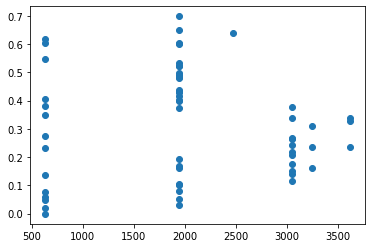

In [5]:
from matplotlib import pyplot as plt 


# what's the relationship between pearson value and support in data
# not a strong relationship: model can learn from little data, but also fails to learn with lots of data
to_plot = sorted(zip(all_rs, all_lens), key = lambda x: x[1])
all_rs, all_lens = zip(*to_plot)

plt.plot(all_lens, all_rs, "o")

/home/hltcoe/estengel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars
/home/hltcoe/estengel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


pearson: model 1: 0.31309310344827584 model 2: 0.29416551724137935
MAE: model 1: -0.40218103448275866 model 2: -0.4847310344827586
F1: model 1: 50.993620689655174 model 2: 48.72568965517241


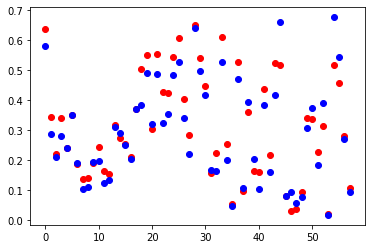

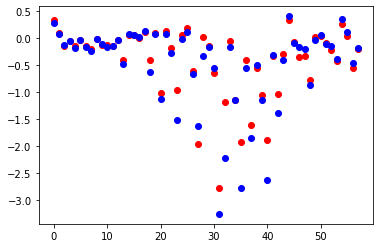

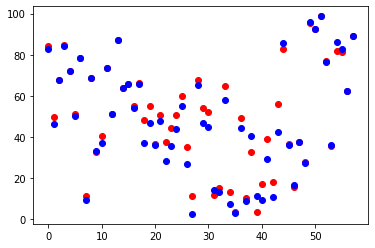

<Figure size 432x288 with 0 Axes>

In [6]:
def compare(model_1, model_2):
    with open(model_1 + '/test/data.json') as f1:
        data_1 = json.load(f1)
    with open(model_2 + '/test/data.json') as f1:
        data_2 = json.load(f1)
    
    pearson_data_1 = pearson(data_1)
    mae_data_1 = mae(data_1)
    f1_data_1 = f1_score(data_1)
    pearson_data_2 = pearson(data_2)
    mae_data_2 = mae(data_2)
    f1_data_2 = f1_score(data_2)
    assert(pearson_data_1.keys() == pearson_data_2.keys())
            
    all_rs_1, all_lens_1, all_r1s_1, all_f1s_1, __ = make_latex(pearson_data_1, mae_data_1, f1_data_1, do_print=False)
    all_rs_2, all_lens_2, all_r1s_2, all_f1s_2, __ = make_latex(pearson_data_2, mae_data_2, f1_data_2, do_print=False)
    

    plt.figure()
    plt.plot([i for i,x in enumerate(all_rs_1)], all_rs_1, "ro")
    plt.plot([i for i,x in enumerate(all_rs_1)], all_rs_2, "bo")
    plt.figure()
    
    plt.plot([i for i,x in enumerate(all_r1s_1)], all_r1s_1, "ro")
    plt.plot([i for i,x in enumerate(all_r1s_1)], all_r1s_2, "bo")
    
    plt.figure()
    
    plt.plot([i for i,x in enumerate(all_f1s_1)], all_f1s_1, "ro")
    plt.plot([i for i,x in enumerate(all_f1s_1)], all_f1s_2, "bo")
    
    plt.figure()
    
    # micro average pearsons and r1s, macro average 
    p_avg_1 = np.mean(all_rs_1)
    p_avg_2 = np.mean(all_rs_2)
    
    mae_avg_1 = np.mean(all_r1s_1)
    mae_avg_2 = np.mean(all_r1s_2)
    
    f1_avg_1 = np.mean(all_f1s_1)
    f1_avg_2 = np.mean(all_f1s_2)
    
    print(f"pearson: model 1: {p_avg_1} model 2: {p_avg_2}")
    print(f"MAE: model 1: {mae_avg_1} model 2: {mae_avg_2}")
    print(f"F1: model 1: {f1_avg_1} model 2: {f1_avg_2}")

    
# MODEL_1 = "/exp/estengel/miso/decomp/models/train_combined_random_seed2.ckpt"
# MODEL_1 = "/exp/estengel/miso/decomp/models/pre_mask_fix/train_combined_random_order.ckpt/"
# MODEL_2 = "/exp/estengel/miso/decomp/models/train_best_order_mask_unshared.ckpt/"
# MODEL_1 = "/exp/estengel/miso/decomp/models/train_separate_bilinear.ckpt"
MODEL_1 = "/exp/estengel/miso/decomp/models/reentrant_train_new_decomp_syntax.ckpt"
MODEL_2 = "/exp/estengel/miso/decomp/models/reentrant_train_new_decomp_semantics.ckpt"
compare(MODEL_1, MODEL_2)
    
    
    
        

In [17]:
from copy import copy
from collections import defaultdict 

def baseline(res_d_param):
#     res_d = copy(res_d_param)
    to_ret = defaultdict(dict)
    for attr_key in res_d_param.keys():
#         true = res_d[attr_key]['true_val_list']
        true, pred = get_true_pred(res_d_param, attr_key)
        median = np.median(true)
        pred = [median for i in range(len(true))]
        if "protorole" not in attr_key:
            pred_val_key = 'pred_val_with_node_ids'
            true_val_key = 'true_val_with_node_ids'
        else:
            pred_val_key = 'pred_val_with_edge_ids'
            true_val_key = 'true_val_with_edge_ids'
        
#         print(res_d_param[attr_key].keys())
        pred_with_keys = res_d_param[attr_key][pred_val_key]
        for k in pred_with_keys.keys():
            pred_with_keys[k] = median 
            
        to_ret[attr_key][pred_val_key] = pred_with_keys
        to_ret[attr_key][true_val_key] = res_d_param[attr_key][true_val_key]
    return to_ret

baseline_data = baseline(data)

pearson_baseline = pearson(baseline_data)
mae_baseline = mae(baseline_data)
f1_baseline = f1_score(baseline_data)  
        
    
all_rs_baseline, all_lens_baseline, all_r1s_baseline, all_f1s_baseline, dev_f1_baseline_threshes = make_latex(pearson_baseline, mae_baseline, f1_baseline, do_print=True)



/home/hltcoe/estengel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars



\begin{table}[h]
    \centering
    \resizebox{\columnwidth}{!}{%
    \begin{tabular}{lll|c|c}
    \hline
     & & Property & Pearson R & F1 \\
    \hline

\ldelim\{{44}{3mm}[\parbox{3mm}{\rotatebox[origin=c]{90}{node-level}}] &  & factuality-factual & nan & 75.15\\
 & \ldelim\{{6}{3mm}[\parbox{3mm}{\rotatebox[origin=c]{90}{genericity}}] & arg-abstract & nan & 40.04\\
 &  & arg-kind & nan & 67.61\\
 &  & arg-particular & nan & 83.1\\
 &  & pred-dynamic & nan & 72.49\\
 &  & pred-hypothetical & nan & 44.16\\
 &  & pred-particular & nan & 77.47\\
 & \ldelim\{{11}{3mm}[\parbox{3mm}{\rotatebox[origin=c]{90}{time}}] & dur-centuries & nan & 10.14\\
 &  & dur-days & nan & 68.72\\
 &  & dur-decades & nan & 29.89\\
 &  & dur-forever & nan & 37.93\\
 &  & dur-hours & nan & 73.66\\
 &  & dur-instant & nan & 55.98\\
 &  & dur-minutes & nan & 86.28\\
 &  & dur-months & nan & 63.25\\
 &  & dur-seconds & nan & 65.33\\
 &  & dur-weeks & nan & 54.02\\
 &  & dur-years & nan & 65.03\\
 & \ldelim\{{26}{3

In [24]:
##### TEST ######

test_path = os.path.join(MODEL_DIR, "test")
with open(os.path.join(test_path, "data.json")) as f1:
    test_data = json.load(f1)
    

# print(test_data.keys())


test_pearson_data = pearson(test_data)

test_mae_data = mae(test_data)
test_f1_data = f1_score(test_data, dev_f1_threshes)

# print(test_data['factuality-factual']['pred_val_with_node_ids'])
test_baseline_data = baseline(test_data)

test_pearson_baseline = pearson(test_baseline_data)
test_mae_baseline = mae(test_baseline_data)
test_f1_baseline = f1_score(test_baseline_data, dev_f1_baseline_threshes)  
        
    
test_rs_baseline, test_lens_baseline, test_r1s_baseline, test_f1s_baseline, __ = make_latex(pearson_baseline, mae_baseline, f1_baseline, do_print=False, baseline = True)


test_rs, test_lens, test_r1s, test_f1s, test_f1_threshes = make_latex(test_pearson_data, 
                                                                      test_mae_data, 
                                                                      test_f1_data, 
                                                                      do_print=True,
                                                                      baseline_data = test_f1s_baseline)




print(f"avg baseline f1: {sum(test_f1s_baseline)/len(test_f1s_baseline)}")
print(f"avg test f1: {sum(test_f1s)/len(test_f1s)}")
print(f"avg test rho: {sum(test_rs)/len(test_rs)}")



\begin{table}[h]
    \centering
    \resizebox{\columnwidth}{!}{%
    \begin{tabular}{lll|c|c|c}
    \hline
     \multirow{2}{*}{} & \multirow{2}{*}{} & \multirow{2}{*}{Property} & \multirow{2}{*}{Pearson $\rho$} & F1  & F1 \\
                       &                   &                           &                                 & (baseline) & (model)   \\ 
    \hline

\ldelim\{{44}{3mm}[\parbox{3mm}{\rotatebox[origin=c]{90}{node-level}}] &  & factuality-factual & 0.6388* & 75.15 & 83.80\\
 & \ldelim\{{6}{3mm}[\parbox{3mm}{\rotatebox[origin=c]{90}{genericity}}] & arg-abstract & 0.3437* & 40.04 & 48.70\\
 &  & arg-kind & 0.2215* & 67.61 & 67.41\\
 &  & arg-particular & 0.3388* & 83.10 & 84.62\\
 &  & pred-dynamic & 0.2415* & 72.49 & 72.10\\
 &  & pred-hypothetical & 0.3497* & 44.16 & 50.13\\
 &  & pred-particular & 0.1872* & 77.47 & 78.21\\
 & \ldelim\{{11}{3mm}[\parbox{3mm}{\rotatebox[origin=c]{90}{time}}] & dur-centuries & 0.1374* & 10.14 & 9.76\\
 &  & dur-days & 0.1392* & 68.72 & 

/home/hltcoe/estengel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


In [67]:



# get residuals
